# Im gonna make the graph representations of the smiles molecules

In [1]:
#standard packages
import time
import torch
import pickle
import dill
import numpy as np
import unimol_tools as um
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import TAGConv
from torch.nn import Sequential, Linear, ReLU

#visualise graphs
import networkx as nx
from torch_geometric.utils import to_networkx

#loading data
import pandas as pd
import os

#turning smiles into GRaphs
from torch_geometric.utils import from_smiles
from torch_geometric.data import Data, Batch
from rdkit import Chem
from rdkit.Chem import Draw

## Loading data

In [2]:
#data path
data_path = "data/raw"

# Load train and test sets
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
test_df = pd.read_csv(os.path.join(data_path, "test.csv"))

### Exploring smiles

*CC(*)c1ccccc1C(=O)OCCCCCC
Data(x=[19, 9], edge_index=[2, 38], edge_attr=[38, 3], smiles='*CC(*)c1ccccc1C(=O)OCCCCCC')


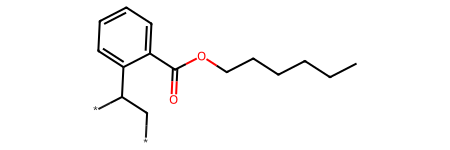

In [17]:
smiles_ex = train_df['SMILES'][0] # example from data set
print(smiles_ex)

# standard way to visualise the molecule
mol_pic = Chem.MolFromSmiles(smiles_ex)

#turn into specified data structure from smiles
data_ex = from_smiles(smiles_ex)

print(data_ex) 
mol_pic

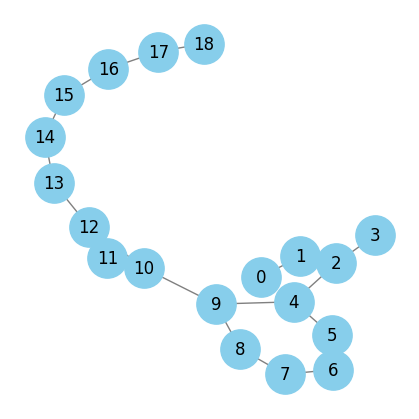

Ellipsis

In [4]:
# Visualise moelcules in graph way
def Vis_SMILES_G(data)->None:    
    G = to_networkx(data, to_undirected=True)

    plt.figure(figsize=(4,4))
    nx.draw(G, with_labels=True, node_color="skyblue", node_size=800, edge_color="gray")
    plt.show()
    return ...

Vis_SMILES_G(data_ex)

## General Mechanism
This built in function uses a commmonly used library known as RDKIT to turn smiles into molecules and then it is turned into a graph. From theRDKit library a lot of features node and edge wise are created immediatly. I just let the function caculate all of them.

### Understanding the features in the graph
Edges attr. Each bond has three features either 1 for single bond 2 for double bond 12 for aromatic bonds in the benzene ring.

Second column is for "stereochemistry / conjugation flag" means bond direction apperantly

Third column: aromatic flag. Just means if the molecule is in a benzene ring

In [18]:
# View edge attributes
data_ex.edge_attr

tensor([[ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  1],
        [ 1,  0,  1],
        [ 2,  0,  1],
        [ 1,  0,  1],
        [ 2,  0,  1],
        [ 1,  0,  1],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0]])

### Molecule node features
Each of the pre built features is 9 features
- Feature1: Atomic number (H=1, C=6, O=8, etc., prob we should make one hot enc)
- Feature2: Chirality ( 1 if it is chiral, this if you mirror it stops being the same molecule. "think about how your hands look diffrentfrom eachother causethey are mirrored")
- Feature3: Degree of node
- Feature4: Formal Charge, (Charge estimated at that molecule)
- Feature5: Number of hydrogens attached
- Feature6: Hybridization (explains what type of sp orbital it has gives a number but we should make it one hot encoding )
- Feature7: Aromatic flag (is it aromatic bond, "deslocation of the bond", for us that usually means in a benzene ring)
- Feature8: Ring membership (is the atom part of a ring)

In [6]:
data_ex.x

tensor([[0, 0, 1, 5, 0, 0, 0, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [0, 0, 1, 5, 0, 0, 0, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 0, 0],
        [8, 0, 1, 5, 0, 0, 3, 0, 0],
        [8, 0, 2, 5, 0, 0, 3, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0]])

Ill create a new column with all the converted graphs

In [7]:
train_df["graph"] = train_df["SMILES"].apply(from_smiles)

# Very Important!
These are polymers which are very long chains, the actual graph would be a ery long chain of our monomers (The smiles we are actually given). So I am creating here a small function that will produce the corresponding molecule for a set lenght. These small chains are called oligomers.

I haven't checked the following code if it is correct but it provides an output I will check robustness another day

In [4]:
from rdkit import Chem

def _neighbor_idx(mol, atom_idx):
    """Return the single neighbor index of a star atom."""
    nbrs = [n.GetIdx() for n in mol.GetAtomWithIdx(atom_idx).GetNeighbors()]
    if len(nbrs) != 1:
        raise ValueError(f"Star atom at idx {atom_idx} does not have exactly one neighbor.")
    return nbrs[0]

def SMILES_To_Oligomer(monomer_smiles: str, length: int, cap_ends: bool = True) -> str:
    """
    Build an oligomer SMILES by connecting monomer units at '*' with SINGLE bonds.
    First '*' in the SMILES string = HEAD, second '*' = TAIL.
    If cap_ends=True, terminal '*' atoms are removed (implicit H completes valence).
    """
    if monomer_smiles.count("*") != 2:
        raise ValueError("Monomer must have exactly 2 connection points [*].")

    # find positions of '*' in the SMILES string
    star_positions = [i for i, ch in enumerate(monomer_smiles) if ch == "*"]
    if len(star_positions) != 2:
        raise ValueError("Could not locate exactly 2 '*' in SMILES string.")

    # RDKit mol
    mono = Chem.MolFromSmiles(monomer_smiles)
    if mono is None:
        raise ValueError("Invalid monomer SMILES.")

    # collect star atom indices in same order as in SMILES string
    atoms = list(mono.GetAtoms())
    stars = [a.GetIdx() for a in atoms if a.GetSymbol() == "*"]

    # this mapping isn't guaranteed from RDKit, so we align with string order
    # pick the atom whose order in MolToSmiles matches the SMILES positions
    # simpler assumption: just treat the first in list as HEAD, second as TAIL
    head_star, tail_star = stars[0], stars[1]

    # Start oligomer
    oligomer = Chem.Mol(mono)
    open_end = tail_star  # grow from tail

    for _ in range(length - 1):
        mono2 = Chem.Mol(mono)
        stars2 = [a.GetIdx() for a in mono2.GetAtoms() if a.GetSymbol() == "*"]
        if len(stars2) != 2:
            raise ValueError("Attachment monomer lost its two '*' atoms.")
        head2, tail2 = stars2  # head2 = first star of new monomer, tail2 = second

        combined = Chem.CombineMols(oligomer, mono2)
        rw = Chem.RWMol(combined)
        offset = oligomer.GetNumAtoms()

        # indices inside combined
        open_star_idx = open_end
        head_idx = head2 + offset
        tail_idx = tail2 + offset

        # connect neighbor of open_end ↔ neighbor of head2
        n1 = _neighbor_idx(rw, open_star_idx)
        n2 = _neighbor_idx(rw, head_idx)
        rw.AddBond(n1, n2, Chem.BondType.SINGLE)

        # remove consumed stars
        for idx in sorted([open_star_idx, head_idx], reverse=True):
            rw.RemoveAtom(idx)

        # adjust tail_idx after deletions
        removed = sorted([open_star_idx, head_idx])
        for r in removed:
            if tail_idx > r:
                tail_idx -= 1

        oligomer = rw.GetMol()
        open_end = tail_idx  # carry forward the new tail

    if cap_ends:
        rw = Chem.RWMol(oligomer)
        end_stars = [a.GetIdx() for a in rw.GetAtoms() if a.GetSymbol() == "*"]
        for idx in sorted(end_stars, reverse=True):
            rw.RemoveAtom(idx)
        oligomer = rw.GetMol()

    Chem.SanitizeMol(oligomer)
    return Chem.MolToSmiles(oligomer)


def SMILES_To_Oligomer_Graph(monomer_smiles: str, length: int):
    oligo_smiles = SMILES_To_Oligomer(monomer_smiles, length, cap_ends=True)
    return from_smiles(oligo_smiles)


 Showing a simple example of the molecule vs its oligomer

Data(x=[17, 9], edge_index=[2, 34], edge_attr=[34, 3], smiles='CCCCCCOC(=O)c1ccccc1CC')


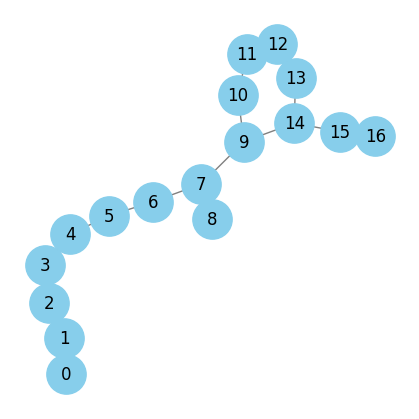

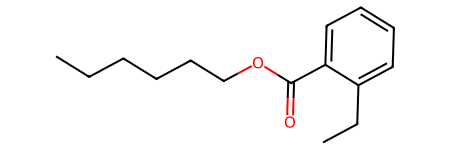

In [9]:
#Example
oligomer_ex = SMILES_To_Oligomer_Graph(smiles_ex, 1) # Generate graph data
print(oligomer_ex)
Vis_SMILES_G(oligomer_ex) # visualise graph form
mol_ex = Chem.MolFromSmiles(SMILES_To_Oligomer(smiles_ex, 1))
mol_ex # visualise in chemical formula for

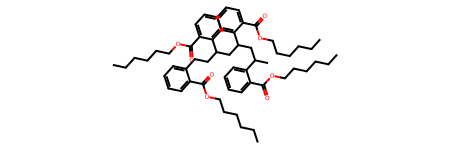

In [10]:
# Showing in alternative length form
mol_ex = Chem.MolFromSmiles(SMILES_To_Oligomer(smiles_ex, 4))
mol_ex

## 3D representations of SMILES 
Based on: https://arxiv.org/pdf/2306.15065. Covalent bonds can be restrictive in what they represent. We instead look at non-covalent, which capture more of the 3D structure of the molecule, as well as more obscure bonds (hydrogen bonds, van der Waals forces). 

In [4]:
from rdkit.Chem import AllChem

def fix_wildcards(smiles: str) -> str | None:
    """
    Replace wildcard atoms (*) in a SMILES with hydrogens (H).
    If sanitization fails, remove the wildcard atoms entirely.
    Returns a valid, sanitized SMILES or None if irrecoverable.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Replace wildcard atoms (*) with hydrogens
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 0:
                atom.SetAtomicNum(1)

        AllChem.SanitizeMol(mol)
        return Chem.MolToSmiles(mol)

    except Exception:
        # If that fails, try deleting the wildcard substructure
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return None

            # Delete all wildcard substructures
            mol = Chem.DeleteSubstructs(mol, Chem.MolFromSmarts('[#0]'))
            
            if mol.GetNumAtoms() == 0:
                return smiles
            
            AllChem.SanitizeMol(mol)
            return Chem.MolToSmiles(mol)
        except Exception:
            # If still invalid, skip it
            return smiles

In [134]:
def find_insert_positions(long_list: list, short_list: list):
    insertions = []
    i = j = 0
    placeholder = np.array([0.0, 0.0, 0.0])
    while i < len(long_list):
        # print(long_list)
        # print(short_list)
        if j < len(short_list) and long_list[i] == short_list[j]:
            i += 1
            j += 1
        else:
            short_list.insert(j, long_list[i])
            insertions.append(j)
    assert np.array_equal(short_list, long_list)
    return insertions

In [ ]:
def gasteiger_charges(mol, nIter=100):
    """
    Compute Gasteiger partial charges safely.
    Returns a list of floats (no NaNs; failed atoms = 0.0).
    """
    mol = Chem.AddHs(mol)
    Chem.SanitizeMol(mol)
    
    try:
        AllChem.ComputeGasteigerCharges(mol, nIter=nIter)
    except Exception as e:
        # complete failure → all zeros
        return [0.0] * mol.GetNumAtoms()

    charges = []
    for atom in mol.GetAtoms():
        try:
            c = atom.GetProp('_GasteigerCharge')
            # handle NaN, inf, missing, etc.
            if c in ('nan', 'inf', '-inf', '', '-nan'):
                c = 0.0
            else:
                c = float(c)
        except KeyError:
            # property missing → fallback
            c = 0.0
        charges.append(c)
    
    return charges

In [150]:
from torch_geometric.data import Data

x_map = {
    'atomic_num':
    list(range(0, 119)),
    'chirality': [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER',
        'CHI_TETRAHEDRAL',
        'CHI_ALLENE',
        'CHI_SQUAREPLANAR',
        'CHI_TRIGONALBIPYRAMIDAL',
        'CHI_OCTAHEDRAL',
    ],
    'degree':
    list(range(0, 11)),
    'formal_charge':
    list(range(-5, 7)),
    'num_hs':
    list(range(0, 9)),
    'num_radical_electrons':
    list(range(0, 5)),
    'hybridization': [
        'UNSPECIFIED',
        'S',
        'SP',
        'SP2',
        'SP3',
        'SP3D',
        'SP3D2',
        'OTHER',
    ]
}

atom_to_idx = {
    'C': 0,
    'H': 1,
    'O': 2,
    'N': 3,
    'P': 4,
    'Cl': 5,
    'F': 6,
    'Br': 7,
    'S': 8,
    'Si': 9,
    'Other': 10
}

def create_non_covalent_graph(
    smiles: list, 
    mol_repr: dict, 
    interval: list, 
    L: int = 1, 
):
    mol = Chem.MolFromSmiles(smiles)
    # mol = Chem.AddHs(mol)
    coords = mol_repr['atomic_coords']
    N = mol.GetNumAtoms()
    
    if mol.GetNumAtoms() != coords.shape[0]:
        placeholder = np.zeros((3,))
        longer = list(atom.GetAtomicNum() for atom in mol.GetAtoms())
        shorter = list(mol_repr['atomic_symbol'])
        indices = find_insert_positions(longer, shorter)
        for idx in indices: 
            coords = np.insert(coords, idx, placeholder, axis=0)
        
        
    assert mol.GetNumAtoms() == coords.shape[0], f'mol: {mol.GetNumAtoms()}, coords: {coords.shape[0]}\n {list(atom.GetSymbol() for atom in mol.GetAtoms())}\n {mol_repr['atomic_symbol']}'
    
    
    atoms = list(mol.GetAtoms())
    dist_matrix = np.zeros((N, N))
    dot_products = np.zeros((N, N))
    charges = gasteiger_charges(mol)
    centroid = np.mean(coords, axis=0)
    
    if mol.GetNumAtoms() == coords.shape[0]:
        # compute distances
        for i, atom_i in enumerate(coords):
            for j, atom_j in enumerate(coords):
                dist_matrix[i, j] = np.linalg.norm(atom_i - atom_j)
                dot_products[i, j] = np.dot(atom_i, atom_j)
        
        # compute edges and edge_features     
        coo_edges = []
        edge_features = []
        for i in range(N):
            for j in range(N):
                if i != j and interval[0] <= dist_matrix[i, j] < interval[1]:
                    coo_edges.append([i, j])
                    
                    features = []
                    features.append(dot_products[i, j])
                    edge_features.append(features)

        # compute node features 
        node_features_basic = np.zeros((N, 13))
        for i in range(N):
            features = []
            features.append(np.linalg.norm(coords[i, :] - centroid))
            features.append(x_map['atomic_num'].index(atoms[i].GetAtomicNum()))
            features.append(x_map['degree'].index(atoms[i].GetTotalDegree())) # it might be nice to include Hs
            features.append(x_map['formal_charge'].index(atoms[i].GetFormalCharge()))
            features.append(x_map['hybridization'].index(str(atoms[i].GetHybridization())))
            features.append(int(atoms[i].GetIsAromatic()))
            features.append(x_map['num_hs'].index(atoms[i].GetTotalNumHs()))
            features.append(int(atoms[i].IsInRing()))
            features.append(x_map['chirality'].index(str(atoms[i].GetChiralTag())))
            features.append(x_map['num_radical_electrons'].index(atoms[i].GetNumRadicalElectrons()))
            features.append(atoms[i].GetExplicitValence())
            features.append(atoms[i].GetMass())
            features.append(charges[i])
            
            node_features_basic[i, :] = features
            
        # compute geometric node features
        node_features_geo = np.zeros((N, 11))
        
        for edge in coo_edges:
            atom_i, atom_j = edge
            atom_j_symbol = mol.GetAtomWithIdx(atom_j).GetSymbol()
            if atom_j_symbol in atom_to_idx:
                node_features_geo[atom_i, atom_to_idx[atom_j_symbol]] += 1 
            else:
                node_features_geo[atom_i, atom_to_idx['Other']] += 1 
                    
        node_features = np.concat((node_features_basic, node_features_geo), axis=-1)
        coo_edges = np.array(coo_edges).T
        edge_features = np.array(edge_features)
        
        return Data(
            x=torch.from_numpy(node_features).float(),
            edge_index=torch.tensor(coo_edges, dtype=torch.long).contiguous(),
            edge_attr=torch.from_numpy(edge_features).float(),
            pos=torch.from_numpy(coords).float()
        )
    
    else:
        # compute node features 
        node_features_basic = np.zeros((N, 11))
        for i in range(N):
            features = []
            features.append(np.linalg.norm(coords[i, :] - centroid))
            features.append(x_map['atomic_num'].index(atoms[i].GetAtomicNum()))
            features.append(x_map['degree'].index(atoms[i].GetTotalDegree())) # it might be nice to include Hs
            features.append(x_map['formal_charge'].index(atoms[i].GetFormalCharge()))
            features.append(x_map['hybridization'].index(str(atoms[i].GetHybridization())))
            features.append(int(atoms[i].GetIsAromatic()))
            features.append(x_map['num_hs'].index(atoms[i].GetTotalNumHs()))
            features.append(int(atoms[i].IsInRing()))
            features.append(x_map['chirality'].index(str(atoms[i].GetChiralTag())))
            features.append(x_map['num_radical_electrons'].index(atoms[i].GetNumRadicalElectrons()))
            features.append(atoms[i].GetExplicitValence())
            features.append(atoms[i].GetMass())
            features.append(charges[i])
            
            node_features_basic[i, :] = features
    
        coords = np.zeros((mol.GetNumAtoms(), 3))
        fallback = from_smiles(smiles, with_hydrogen=True)
        node_features_geo_fallback = np.zeros((N, 11))
        node_features = np.concat((node_features_basic, node_features_geo_fallback), axis=-1)
        edge_features = np.zeros((fallback.edge_index.shape[1], 2))
        
        return Data(
            x=torch.from_numpy(node_features).float(),
            edge_index=fallback.edge_index,
            edge_attr=torch.from_numpy(edge_features).float(),
            pos=torch.from_numpy(coords).float()
        )


In [10]:
model = um.UniMolRepr(data_type='molecule', remove_hs=False, model_name='unimolv2', model_size='1.1B', batch_size=1)

2025-10-31 21:19:06 | unimol_tools\models\unimolv2.py | 176 | INFO | Uni-Mol Tools | Loading pretrained weights from c:\Users\garga\Documents\Uni\DSAIT4305\dsait-4305-polymer-prediction\.venv\Lib\site-packages\unimol_tools\weights\modelzoo/1.1B/checkpoint.pt


In [5]:
smiles_list = [fix_wildcards(smiles) for smiles in train_df['SMILES']]
empty_indices = [i for i, s in enumerate(smiles_list) if s == '']
smiles_list = [s for s in smiles_list if s]

In [16]:
from collections import Counter
total_counts = Counter()

for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
        total_counts.update(atoms)
    else:
        print(f"{smi}: Invalid SMILES")

# Print total atom counts across all SMILES
print("Total atom counts across all SMILES:")
for el, cnt in sorted(total_counts.items()):
    print(f"{el} = {cnt}")

Total atom counts across all SMILES:
* = 4
B = 2
Br = 182
C = 207681
Ca = 1
Cd = 1
Cl = 342
F = 5720
Ge = 5
H = 141
N = 13143
Na = 6
O = 27981
P = 298
S = 1442
Se = 6
Si = 551
Sn = 7
Te = 1


In [12]:
unimol_reprs = model.get_repr(smiles_list, return_atomic_reprs=True)
# # CLS token repr
# print(np.array(unimol_repr['cls_repr']).shape)
# # atomic level repr, align with rdkit mol.GetAtoms()
# print(np.array(unimol_repr['atomic_coords']).shape)

2025-10-31 21:19:22 | unimol_tools\data\conformer.py | 452 | INFO | Uni-Mol Tools | Start generating conformers...
100%|██████████| 7973/7973 [16:00<00:00,  8.30it/s]  
2025-10-31 21:35:22 | unimol_tools\data\conformer.py | 467 | INFO | Uni-Mol Tools | Succeeded in generating conformers for 100.00% of molecules.
2025-10-31 21:35:22 | unimol_tools\data\conformer.py | 484 | INFO | Uni-Mol Tools | Succeeded in generating 3d conformers for 99.22% of molecules.
2025-10-31 21:35:22 | unimol_tools\data\conformer.py | 493 | INFO | Uni-Mol Tools | Failed 3d conformers indices: [67, 343, 812, 856, 891, 987, 1019, 1232, 1539, 1569, 1678, 1730, 1739, 1760, 2004, 2095, 2097, 2172, 2182, 2220, 2349, 2353, 2382, 2464, 2861, 2987, 3083, 3131, 3165, 3172, 3295, 3389, 3604, 3659, 3815, 3953, 4189, 4321, 4836, 4991, 5062, 5110, 5502, 5532, 5544, 5575, 5690, 5774, 5839, 5845, 6023, 6062, 6451, 6456, 6494, 6656, 6726, 6737, 6840, 7414, 7492, 7865]
2025-10-31 21:35:23 | unimol_tools\tasks\trainer.py | 78 | 

In [13]:
with open('reprs_v2.pl', 'wb') as f:
    dill.dump(unimol_reprs, f) 

In [ ]:
indices_diff = {
    70: [6, 7, 8], 
    247: [0], 
    287: [0], 
    775: [0], 
    1056: [0],
    1086: [0],
    1109: [0],
    1164: [0],
    1184: [0],
    1201: [0],
    1277: [0],
    1465: [0],
    1601: [0],
    1649: [0],
    1765: [4, 6, 8, 10, 12],
    1799: [0],
    2435: [1, 2, 4, 6, 7, 8],
    2527: [0],
    2655: [0],
    2746: [0],
    2875: [0],
    2968: [0],
    3148: [0],
    3407: [0, 3],
    3599: [0],
    3664: [0],
    4130: [1, 2, 8, 9, 11, 12, 13, 15, 16, 17],
    4290: [1, 2, 4, 7, 9, 11, 13, 15],
    4610: [0],
    4783: [0, 17],
    5110: [10, 37, 51, 51, 64, 64, 70, 75, 84, 100, 100, 103, 115],
    5277: [0],
    5390: [1, 2, 5, 6, 7, 9, 10, 11],
    5762: [0],
    5774: [0],
    5809: [0],
    5836: [0],
    5978: [0],
    6045: [1, 2, 8, 9, 10, 12, 13, 14],
    6047: [0],
    6243: [0],
    6249: [1, 2, 4],
    6280: [0],
    6427: [3, 4, 10, 11, 15, 16, 20, 21, 23, 24, 25, 25, 25, 26, 26, 26, 27, 28, 29, 30, 31, 32], #
    6501: [3, 5, 8, 10],
    6666: [0],
    6668: [0],
    6785: [0],
    6840: [0], #
    6920: [1, 2, 4, 6, 8, 9],
    6961: [2, 4, 5, 7, 8, 10, 11, 12],
    7129: [0, 11],
    7232: [0],
    7588: [3, 5],
    7699: [0],
    7746: [0],
    7799: [0],
    7866: [0],
    7886: [7, 8, 9],
}

In [117]:
for i, smiles in enumerate(smiles_list):
    shape1 = unimol_reprs['atomic_coords'][i].shape[0]
    shape2 = from_smiles(smiles).x.shape[0]
    shape3 = Chem.MolFromSmiles(smiles).GetNumAtoms()
    if shape1 != shape2:
        print('=========')
        print(i, shape1, shape2, shape3)
        print(list(range(0, max(shape1, shape2))))
        print(list(atom.GetAtomicNum() for atom in Chem.MolFromSmiles(smiles).GetAtoms()))
        print([int(sym) for sym in unimol_reprs['atomic_symbol'][i]])
        print(find_insert_positions(list(atom.GetAtomicNum() for atom in Chem.MolFromSmiles(smiles).GetAtoms()), [int(sym) for sym in unimol_reprs['atomic_symbol'][i]]))

70 6 9 9
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[6, 6, 6, 8, 8, 6, 1, 1, 1]
[6, 6, 6, 8, 8, 6]
[6, 7, 8]
247 8 9 9
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[1, 6, 6, 6, 6, 6, 6, 6, 6]
[6, 6, 6, 6, 6, 6, 6, 6]
[0]
287 40 41 41
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
[1, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6]
[6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6]
[0]
775 18 19 19
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[0]
1056 33 34 34
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[1, 6, 6, 6, 16, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [149]:
mol_repr = {
    'atomic_coords' : unimol_reprs['atomic_coords'][1],
    'atomic_symbol' : unimol_reprs['atomic_symbol'][1]
}
create_non_covalent_graph(smiles_list[1], mol_repr, [0, 2])

Data(x=[45, 24], edge_index=[2, 98], edge_attr=[98, 2], pos=[45, 3])

In [151]:
graphs = []
for i, smiles in enumerate(smiles_list):
    mol_repr = {
            'atomic_coords' : unimol_reprs['atomic_coords'][i],
            'atomic_symbol' : unimol_reprs['atomic_symbol'][i]
        }
        
    data = create_non_covalent_graph(smiles, mol_repr, [0, 2])
    data_torch = from_smiles(smiles)
    data.edge_index = data_torch.edge_index
    edge_features = []
    for edge in data_torch.edge_index.T:
        dist = np.linalg.norm(data.pos[edge[0], :] - data.pos[edge[1], :])
        dot = np.dot(data.pos[edge[0], :], data.pos[edge[1], :])
        features = []
        features.append(dot)
        
        edge_features.append(features)

    edge_attr_np = np.array(edge_features)
    data.edge_attr = torch.from_numpy(edge_attr_np)
    graphs.append(data)
        
train_df['graph_[0A-2A]'] = graphs

In [153]:
intervals = [
    ([2, 4], 'graph_[2A-4A]'), 
    ([4, 6], 'graph_[4A-6A]'), 
    ([6, 8], 'graph_[6A-8A]'),
    ([8, 1000000], 'graph_[8A-infA]')
]

for interval, name in intervals:
    graphs = []
    print(f'at interval {name}')
    for i, smiles in enumerate(smiles_list):
        try:
            mol_repr = {
                'atomic_coords' : unimol_reprs['atomic_coords'][i],
                'atomic_symbol' : unimol_reprs['atomic_symbol'][i]
            }
            
            data = create_non_covalent_graph(smiles, mol_repr, interval)
            graphs.append(data)
        except Exception:
            print(smiles)
            print(i)
        
    
    train_df[name] = graphs

at interval graph_[2A-4A]
at interval graph_[4A-6A]
at interval graph_[6A-8A]
at interval graph_[8A-infA]


In [13]:
with open('reprs.pl', 'rb') as f:
    unimol_reprs = dill.load(f)

In [172]:
for i in range(7973):
    if train_df['graph_[2A-4A]'][i].x.isnan().sum() > 0:
        train_df['graph_[2A-4A]'][i]
        fixed_x = torch.nan_to_num(train_df['graph_[2A-4A]'][i].x, nan=0.0)
        train_df['graph_[2A-4A]'][i].x = fixed_x

In [6]:
from src.preprocessing.rdkit_descriptors import RDKitDescriptorsPreprocessor
mol_desc = RDKitDescriptorsPreprocessor()

In [8]:
graph_descriptors = mol_desc.fit_transform(train_df['SMILES'])

Computing descriptors and fitting scaler on 7973 molecules...


Computing descriptors: 100%|██████████| 7973/7973 [01:45<00:00, 75.41it/s]


Fitted scaler on 217 descriptors


In [9]:
torch.save(graph_descriptors, "data/processed/descs.pt")

In [ ]:
train_df.to_pickle('data/processed/train_processed.pkl')

In [26]:
train_df = pd.read_pickle('data/processed/train_processed.pkl')

In [110]:
mol_ex = Chem.MolFromSmiles('CC(CN1C(=O)C2C3C=CC(C3)C2C1=O)O')
mol_ex = Chem.AddHs(mol_ex)
params = AllChem.ETKDGv3()
params.maxIterations = 10000
Chem.AllChem.EmbedMolecule(mol_ex, params)
mol_ex_block = Chem.MolToMolBlock(mol_ex)
conf = mol_ex.GetConformer()
coords = np.array([list(conf.GetAtomPosition(i)) for i in range(mol_ex.GetNumAtoms())])

In [111]:
AllChem.ComputeGasteigerCharges(mol_ex)
charges = [float(a.GetProp('_GasteigerCharge')) for a in mol_ex.GetAtoms()]

In [27]:

train_df['graph_[0A-2A]'][0].x.shape

torch.Size([17, 24])